In [1]:
#Importing pyspark
from pyspark.sql import SparkSession
#importing pandas
import pandas as pd

In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("NYCTaxi") \
    .getOrCreate()

# File location and type
file_location = "fhvhv_tripdata_2023-02.parquet"
file_type = "parquet"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[hvfhs_license_num: string, dispatching_base_num: string, originating_base_num: string, request_datetime: timestamp_ntz, on_scene_datetime: timestamp_ntz, pickup_datetime: timestamp_ntz, dropoff_datetime: timestamp_ntz, PULocationID: int, DOLocationID: int, trip_miles: double, trip_time: bigint, base_passenger_fare: double, tolls: double, bcf: double, sales_tax: double, congestion_surcharge: double, airport_fee: double, tips: double, driver_pay: double, shared_request_flag: string, shared_match_flag: string, access_a_ride_flag: string, wav_request_flag: string, wav_match_flag: string]

In [3]:
#Create a view or table
temp_table_name = "nyc_taxi_parquet"
#Rename table name
df.createOrReplaceTempView(temp_table_name)

In [4]:
# Perform SQL-like operations
result = spark.sql("select * from nyc_taxi_parquet limit 5")
# Show the result
result.show()

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

In [5]:
#import tabulate library to display tabular form of grouped values 
from tabulate import tabulate

total_trip_miles = df.selectExpr("sum(trip_miles) as total_trip_miles").collect()[0]["total_trip_miles"]
total_revenue = spark.sql("SELECT sum(base_passenger_fare + tolls + bcf + sales_tax + congestion_surcharge + airport_fee + tips) as total_revenue FROM nyc_taxi_parquet").collect()[0]["total_revenue"]
total_charges = spark.sql("SELECT sum(tolls + bcf + sales_tax + congestion_surcharge + airport_fee) as total_charges FROM nyc_taxi_parquet").collect()[0]["total_charges"]

table_data = [
    ['Total Trip Miles', '{:,.2f}'.format(total_trip_miles)],
    ['Total Revenue', '{:,.2f}'.format(total_revenue)],
    ['Total Charges', '{:,.2f}'.format(total_charges)]
]

print(tabulate(table_data, headers=['Category', 'Value'], tablefmt='fancy_grid'))

╒══════════════════╤════════════════╕
│ Category         │ Value          │
╞══════════════════╪════════════════╡
│ Total Trip Miles │ 86,478,929.34  │
├──────────────────┼────────────────┤
│ Total Revenue    │ 506,078,966.80 │
├──────────────────┼────────────────┤
│ Total Charges    │ 88,698,323.28  │
╘══════════════════╧════════════════╛


In [6]:
#Display the schema
df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_

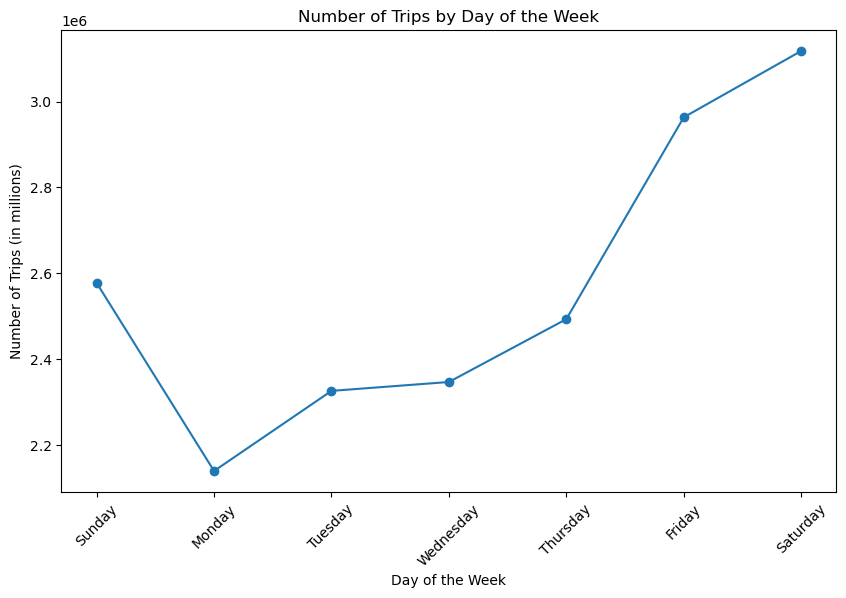

In [7]:
#importing f function from pyspark
import pyspark.sql.functions as F
#import pyplot from matplotlib library to draw static graphs
import matplotlib.pyplot as plt

# Convert timestamp columns to date
df = df.withColumn('request_date', F.to_date(F.col('request_datetime')))
df = df.withColumn('pickup_date', F.to_date(F.col('pickup_datetime')))

# Extract day of the week from the date
df = df.withColumn('day_of_week', F.date_format(F.col('request_date'), 'EEEE'))

# Calculate the count of trips by day of the week
trips_by_day = df.groupBy('day_of_week').count().orderBy(F.when(F.col('day_of_week') == 'Sunday', 1)
                                                         .when(F.col('day_of_week') == 'Monday', 2)
                                                         .when(F.col('day_of_week') == 'Tuesday', 3)
                                                         .when(F.col('day_of_week') == 'Wednesday', 4)
                                                         .when(F.col('day_of_week') == 'Thursday', 5)
                                                         .when(F.col('day_of_week') == 'Friday', 6)
                                                         .otherwise(7))

# Convert Spark DataFrame to Pandas DataFrame for visualization
trips_by_day_pd = trips_by_day.toPandas()

# Define the order of the days of the week
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plot a line chart of trips by day of the week
plt.figure(figsize=(10, 6))
plt.plot(trips_by_day_pd['day_of_week'], trips_by_day_pd['count'], marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips (in millions)')
plt.title('Number of Trips by Day of the Week')
plt.xticks(range(7), days_of_week, rotation=45)
plt.show()

In [8]:
# List of Required Columns
columns = ['request_datetime', 'on_scene_datetime', 'pickup_datetime',       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
#,       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',       'wav_request_flag', 'wav_match_flag']

In [9]:
#Reading the source parquet file
df = pd.read_parquet('fhvhv_tripdata_2023-02.parquet', columns=columns)

In [10]:
#Reading Zones data for join
df_zones = pd.read_csv('taxi+_zone_lookup.csv')

In [11]:
# Dataset joins for PULocation Zones
df2 = pd.merge(df, df_zones, left_on='PULocationID', right_on = "LocationID")
df = df2
del df2
#df = df.drop(['Borough','Zone'])
del df['Borough']
del df['service_zone']
df.rename(columns={'Zone': 'PUL_Zone'}, inplace=True)
df.head()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,LocationID,PUL_Zone
0,2023-02-01 00:12:17,2023-02-01 00:13:34,2023-02-01 00:15:34,2023-02-01 00:25:01,244,74,5.41,567,16.45,0.0,0.39,1.16,0.00,0.0,0.0,12.82,244,Washington Heights South
1,2023-02-01 00:27:16,2023-02-01 00:28:13,2023-02-01 00:28:40,2023-02-01 00:31:30,244,244,0.52,170,7.91,0.0,0.24,0.70,0.00,0.0,0.0,6.40,244,Washington Heights South
2,2023-02-01 00:11:27,2023-02-01 00:13:20,2023-02-01 00:13:28,2023-02-01 00:15:32,244,244,0.28,124,7.91,0.0,0.24,0.70,0.00,0.0,0.0,5.90,244,Washington Heights South
3,2023-02-01 00:17:39,2023-02-01 00:20:20,2023-02-01 00:20:27,2023-02-01 00:34:56,244,263,6.26,869,14.96,0.0,0.45,1.33,0.75,0.0,0.0,16.32,244,Washington Heights South
4,2023-02-01 00:54:30,2023-02-01 00:56:08,2023-02-01 00:58:08,2023-02-01 01:13:51,244,74,5.03,943,17.55,0.0,0.53,1.56,0.00,0.0,0.0,14.98,244,Washington Heights South


In [12]:
# Dataset joins for DOLocation Zones
df2 = pd.merge(df, df_zones, left_on='DOLocationID', right_on = "LocationID")
df = df2
del df2
#df = df.drop(['Borough','Zone'])
del df['Borough']
del df['service_zone']
df.rename(columns={'Zone': 'DOL_Zone'}, inplace=True)
df.head()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,LocationID_x,PUL_Zone,LocationID_y,DOL_Zone
0,2023-02-01 00:12:17,2023-02-01 00:13:34,2023-02-01 00:15:34,2023-02-01 00:25:01,244,74,5.410,567,16.45,0.00,0.39,1.16,0.0,0.0,0.0,12.82,244,Washington Heights South,74,East Harlem North
1,2023-02-01 00:54:30,2023-02-01 00:56:08,2023-02-01 00:58:08,2023-02-01 01:13:51,244,74,5.030,943,17.55,0.00,0.53,1.56,0.0,0.0,0.0,14.98,244,Washington Heights South,74,East Harlem North
2,2023-02-01 00:43:55,2023-02-01 00:45:20,2023-02-01 00:47:13,2023-02-01 00:56:56,244,74,5.070,583,16.07,0.00,0.48,1.43,0.0,0.0,0.0,14.49,244,Washington Heights South,74,East Harlem North
3,2023-02-01 00:27:38,NaT,2023-02-01 00:30:25,2023-02-01 00:38:14,244,74,3.152,469,11.26,0.25,0.35,1.02,0.0,0.0,0.0,9.46,244,Washington Heights South,74,East Harlem North
4,2023-02-01 00:28:58,NaT,2023-02-01 00:32:48,2023-02-01 00:39:27,244,74,2.417,399,10.61,0.00,0.32,0.94,0.0,0.0,0.0,6.73,244,Washington Heights South,74,East Harlem North


In [13]:
#Create a column which is a concatenated form of Pick up and Drop-off location
df['PUL_Zone_to_DOL_Zone'] = df['PUL_Zone'] + '-'+ df['DOL_Zone']

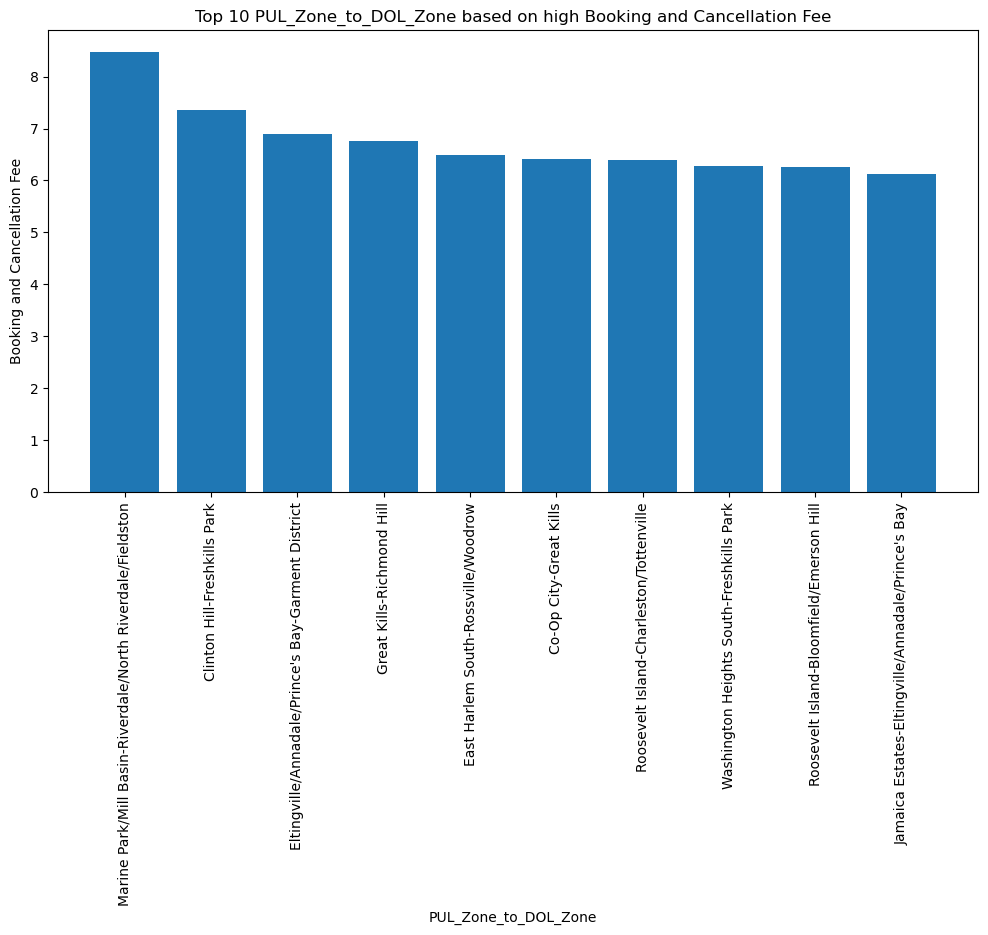

In [28]:
#Bar chart based on Pickup & Drop-Off location with high Booking and Cancellation Fee
pickup_counts = df.groupby('PUL_Zone_to_DOL_Zone')['bcf'].mean().reset_index()
pickup_counts = pickup_counts.sort_values(by='bcf', ascending=False)[:10]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(pickup_counts['PUL_Zone_to_DOL_Zone'], pickup_counts['bcf'])
plt.xticks(rotation=90)
plt.xlabel('PUL_Zone_to_DOL_Zone')
plt.ylabel('Booking and Cancellation Fee')
plt.title('Top 10 PUL_Zone_to_DOL_Zone based on high Booking and Cancellation Fee')
plt.show()

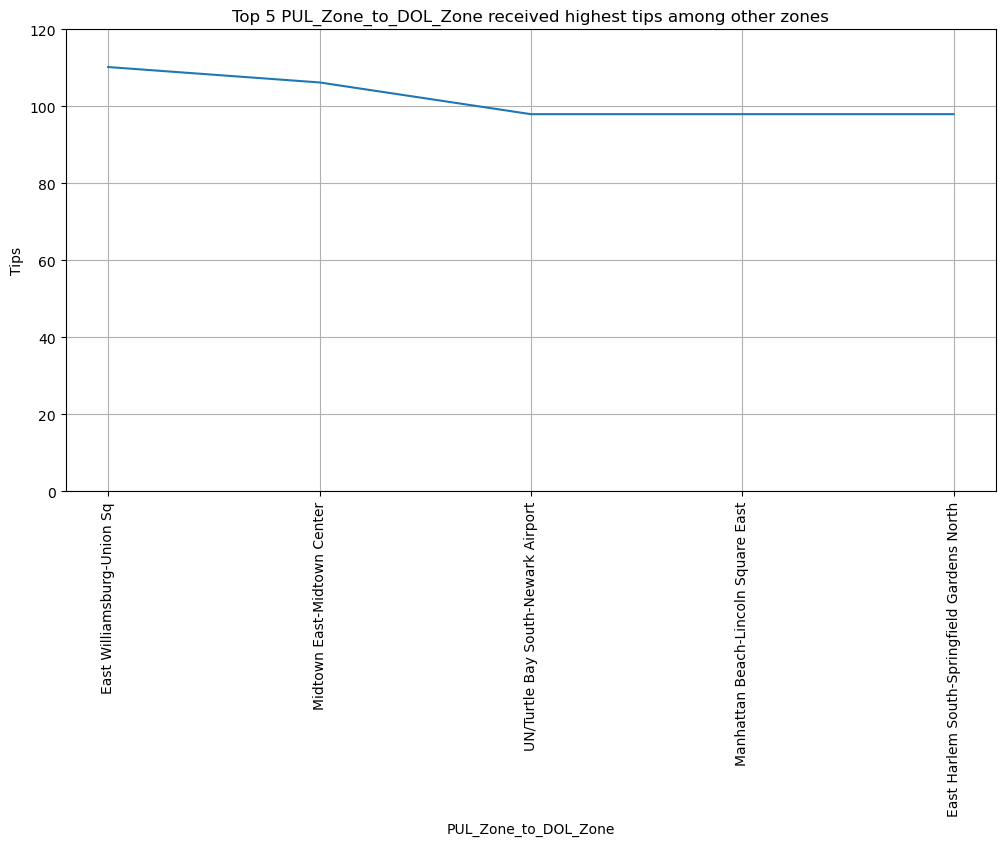

In [43]:
# Line chart based on Pickup & Drop-Off location with maximum tips
pickup_counts = df.groupby('PUL_Zone_to_DOL_Zone')['tips'].max().reset_index()
pickup_counts = pickup_counts.sort_values(by='tips', ascending=False)[:5]
# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.plot(pickup_counts['PUL_Zone_to_DOL_Zone'], pickup_counts['tips'])
plt.xticks(rotation=90)
plt.xlabel('PUL_Zone_to_DOL_Zone')
plt.ylabel('Tips')
plt.ylim(0,120)
plt.title('Top 5 PUL_Zone_to_DOL_Zone received highest tips among other zones')
plt.grid()
plt.show()

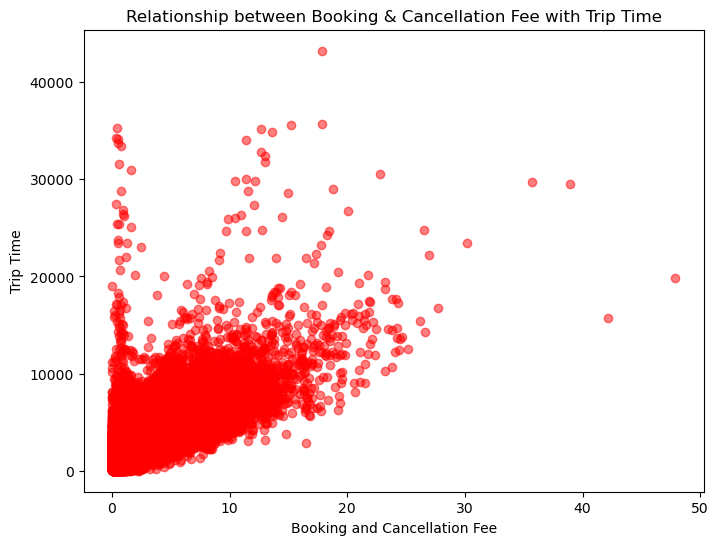

In [47]:
# Scatter Plot: Relationship between Booking and Cancellation Fee with trip time
plt.figure(figsize=(8, 6))
plt.scatter(df['bcf'], df['trip_time'], alpha=0.5, color = 'red')
plt.xlabel('Booking and Cancellation Fee')
plt.ylabel('Trip Time')
plt.title('Relationship between Booking & Cancellation Fee with Trip Time')
plt.show()

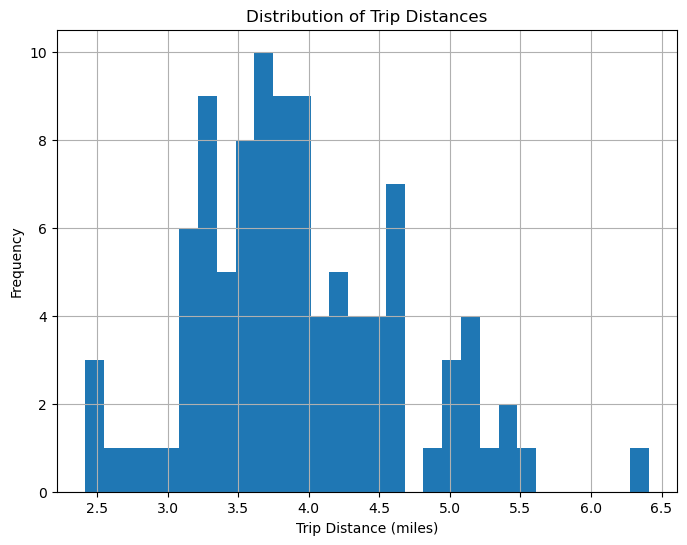

In [29]:
# Histogram: Distribution of trip distances
plt.figure(figsize=(8, 6))
df['trip_miles'].head(100).plot(kind='hist', bins=30)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distances')
plt.grid()
plt.show()

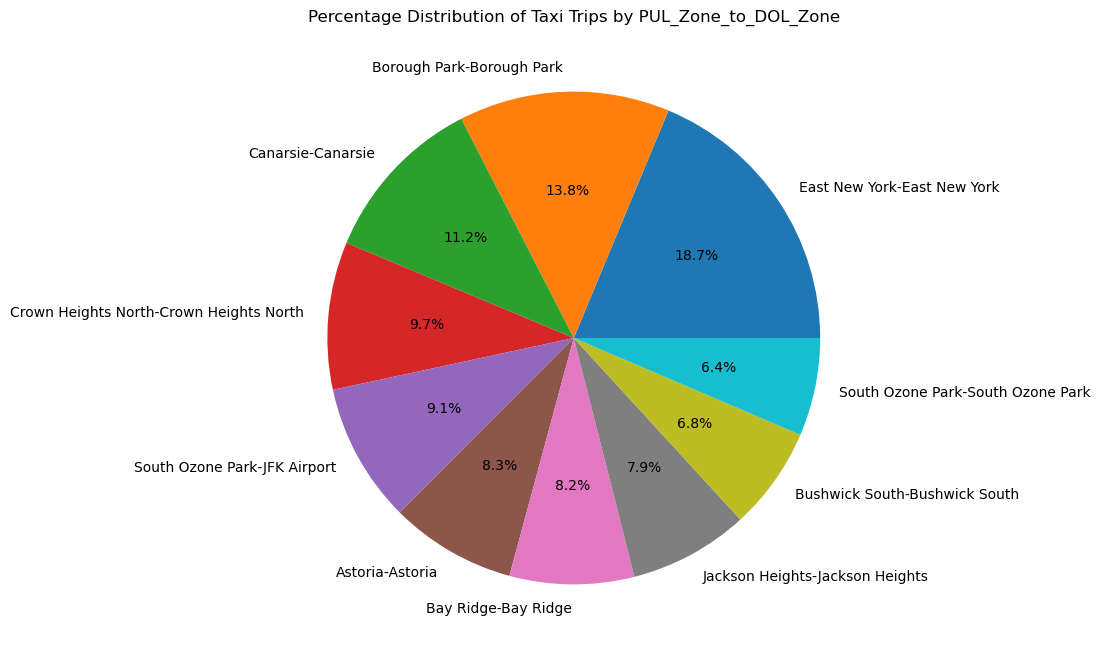

In [30]:
# Pie Chart: Percentage distribution of trips across different PUL_Zone_to_DOL_Zone
plt.figure(figsize=(8, 8))
df['PUL_Zone_to_DOL_Zone'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentage Distribution of Taxi Trips by PUL_Zone_to_DOL_Zone')
plt.ylabel('')
plt.show()

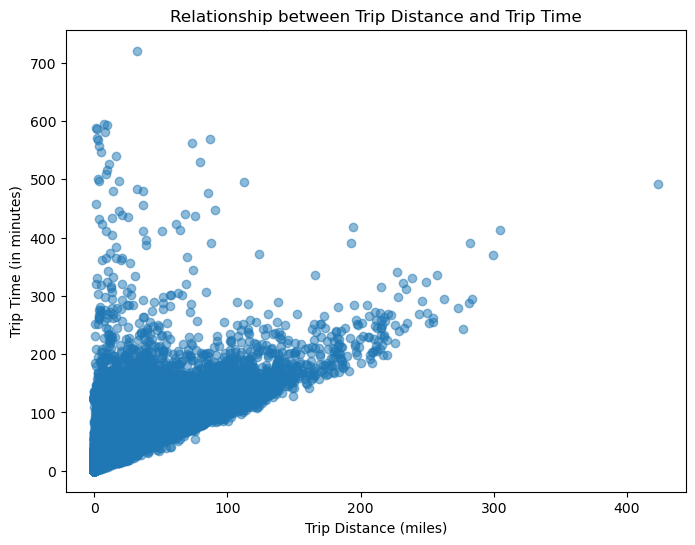

In [31]:
# Scatter Plot: Relationship between trip distance and trip time
plt.figure(figsize=(8, 6))
plt.scatter(df['trip_miles'], df['trip_time']/60, alpha=0.5)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Time (in minutes)')
plt.title('Relationship between Trip Distance and Trip Time')
plt.show()

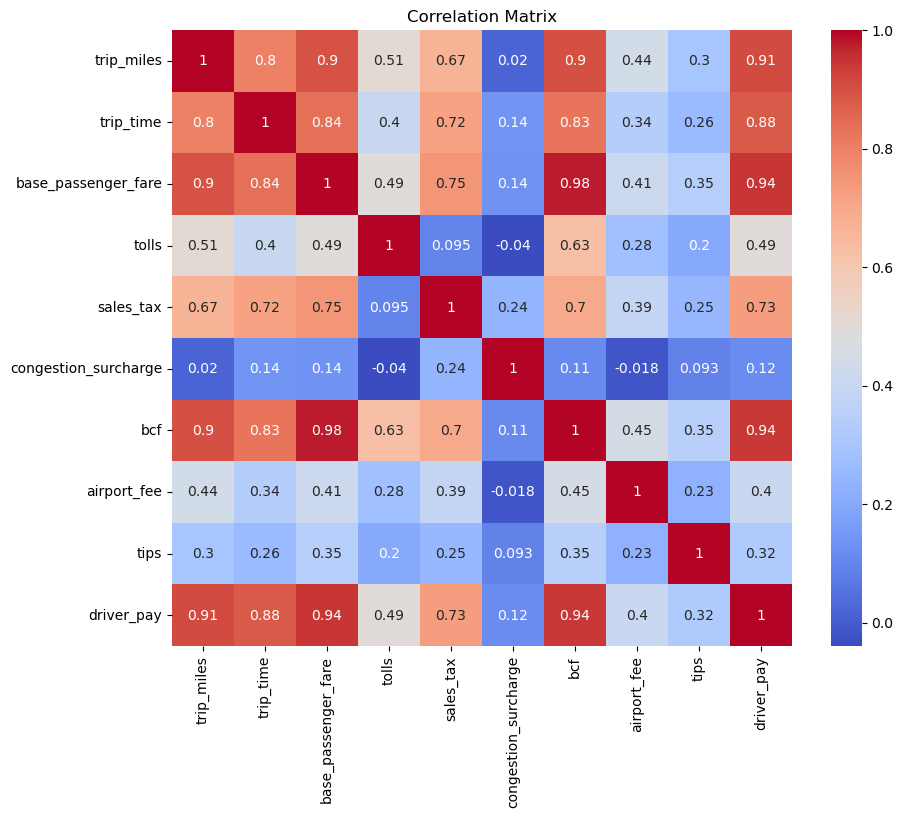

In [36]:
# Heatmap: Correlation matrix
import seaborn as sns
correlation_matrix = df[[ 'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'sales_tax','congestion_surcharge','bcf', 'airport_fee', 'tips', 'driver_pay']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()